# Tutorial: Simple Fit

This will be the main tutorial for $\rm dynamicall^{TM}$, a package for fitting dynamical mass models to kinematic data (It does other stuff too) <!-- TODO: Add link to other parts of the documentation -->

We'll go over the basics of how to use the package and then go into more detail about how to use the different parts of the package in other tutorials

The **default case** for the package assumes that you are trying to fit data from observations of a local group dwarf spheroiodal galaxy i.e. projected positions and line of sight velocities of stars.

This means a couple of things regarding defaults values (on the priors).
We Assume that the observations which you have are stars which contribute a negligible amount to the total mass of the system i.e. `masslesss' tracers, which are embedded in a dark matter halo.

Although you have complete control over the parametrizations and therefore priors which you use, based on previous works we have a set of models and priors which maybe convenient for you to use and which should work with the base case as define above.

(If there is a parametrization of some parameter which is not already included it is particularly easy to define a new model which can then be used with dynamicall)

*Hopefully there is a tutorial on how to do this.*

First start with the imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'
import numpyro
numpyro.enable_x64()
import jax
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)

## TL;DR

In [3]:
jax.local_device_count()

2

In [4]:
jax.devices('cpu')

[CpuDevice(id=0), CpuDevice(id=1)]

You should pretty much always enable double precision when using this package.

If it becomes annoying to keep typing it in every notebook, you can add it to your .zshrc file (or whatever appropriate file for your shell)
```bash
export JAX_ENABLE_X64=True
```

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# use my stylesheet
plt.style.use('/Users/juan/phd/matplotlib/jdefault.mplstyle') # this should be changed something in the repo

#sampling and inference
# import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

#need to get rid of
import numpy as np

# project
from dynamicAll import models,fit,data
from dynamicAll.fit import Fit

In [6]:
# First load mock data
# TODO: use mock data from the package,you idiot
# Lets read in some mock data -- we can also generate fake data for a wide variety of models.
dataSet = pd.read_csv('../../notebooks/data/gs010_bs050_rcrs025_rarcinf_cusp_0064mpc3_df_1000_3_err.dat')
# Theres no error column in this data set, but we can just add it.
error = np.full_like(dataSet['x'],2.0)
# append error to dataSet
dataSet['error'] = error

If only one error is provided I'll assume thats the error for each component of the velocity.
Otherwise you should append an error for each component of the velocity. 

**The naming convention is 'd_' + component name.**

**So for example, if you have a velocity component called 'vz' then the error should be called 'd_vz'**

**NOTE: If you provide the error for one component, you must supply them for all velocity component**

The error on the positions seems to alway be neglected since its usually small so we'll keep ignoring it.

## 1. The Data class
```python
from dynamicAll import data
```
The data module contains a wrapper for your data and comes with several helper functions to visualize the data.
This could help with picking a better parametrization for your model if the default ones arent giving great answers or if you are unsure what to use.

Currently there are three subclassses of the data class,
- MockData
- DCJLData <!--TODO: change this to simulation data -->
- KeckData

Lets start with using mock data

In [7]:
system = data.MockData(dataSet)

### Spatial data
The first thing you might want to do is look at the spatial data and velocity dispersion.
This might influence the particular models you pick for the the tracers and the potential -- and if you have proper motions the velocity anisotropy.

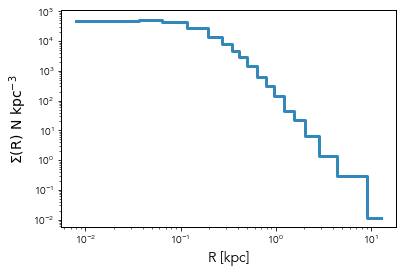

In [8]:
R_center,nu = system.spatial_density() # dumb name, should change it.

fig,ax = plt.subplots()
ax.step(R_center,nu,where='mid')
ax.set(
    xlabel = 'R [kpc]',
    ylabel =r'$\rm\Sigma(R)~N~kpc^{-3}$',
    xscale = 'log',
    yscale = 'log',
); 

#### Preliminary fitting

You can try fitting a plummer, or other model to this data.

Scipy's curve fit is good enough to do this for a simple model like a plummer sphere.
Since the observational data will usually be projected positions, we'll stick to those.

In this case we'll fit our projected data to a plummer sphere.

```python
models.Plummer.projection()
```

If you want something more -- non parametric, you could
1. fit a sum of gaussians to the data -- Thats possible
2. Use B-splines to fit the data.

Depending on your goals one or the other may prove more useful.

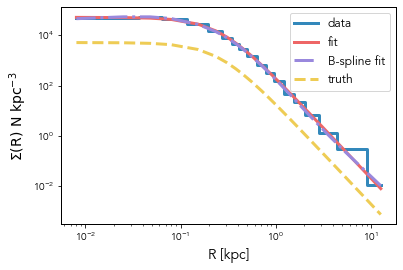

In [9]:
# Define function you want to fit the data to
func = models.Plummer._projection
# plot curve_fit of curve
fig, ax,popt = system.fit_projection(func,p0 = [1e3,0.25])

# plot B-spline fit
ax.plot(R_center,system.bspline_projected(R_center),
    linestyle='-.',
    label='B-spline fit')
# plot truth
ax.plot(R_center,models.Plummer._projection(R_center,1e3,0.25),
    label='truth',
    linestyle ='--')
ax.legend();

What may prove more Useful is to use the photometry to fit the photometry in order to calculate the surface brightness profile. The use those constraints in order to put priors on the tracer density profile, or even fix it all together. This part should be well constrained even with a few stars so it shouldnt affect the results very much.

## Velocity data

### Mass Estimator e.g. $\rm M_{Wolf}$

The simplest thing you might want to do with the velocity data is calculate the velocity dispersion (Average velocity dispersion of your data) and calculate a mass estimate at the half-light radius.

You can do both 
```python
mean_vdisp = system.velocity_dispersion(component='los')
```
or
```python
wolf_mass = system.mass_estimator('Wolf',rhalf= 0.25)
```
If you prefer a different mass estimator, I've included the "Walker" estimator which should give you a similar answer.
If you have proper motions, you could use the mass "Errani" mass estimator as well

Since we're dealing with mock data at the moment we do have all the components so lets estimate all of them

In [10]:
# wolf_mass = system.mass_estimator('Wolf',rhalf= 0.25) # If you're data set has rhalf in it. You dont need to supply it, but it'll work either way

### velocity dispersion: $\rm\sigma_{los}(R)$

If you have sufficient data ($N_{\star}\sim 10^{3}$) It may be useful to inspect the velocity dispersion as a function of radius.

We offer to versions of doing this, Either using binning which works well with a large number of stars, or non-parametrically using B-splines.


Since we're using mock data we have every component, so lets walk through some of the data products you can make.

A simple calculation you can do is the calculate the velocity dispersion as a function of radius.
```python
system.dispersion(ri,vi,error,component,bin_func,bins)
```
This returns three things,
- r_center
- dispersion
- dispersion_error

If that's too much writing, you can instead call dispersion_i() which takes a component argument and returns the corresponding dispersion.
```python
system.dispersion_i(component='los')
```
or if you have 6D data and want to find the dispersion in each of the spherical components
- 'radial'
- 'theta'
- 'phi'

or if you have 5D -- 2D spatial data (propjected position "R") + 3D  velocity (i.e. proper motions) --- you can calculate the two additional dispersions
- 'pmr'
- 'pmt'

When you first initialize the data class, it'll tell you which components are available.

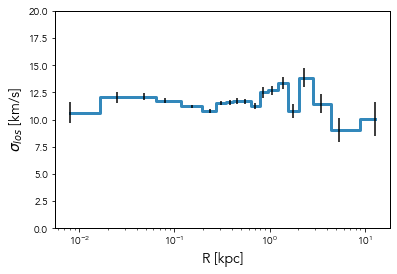

In [11]:
r_center,dispersion,error = system.dispersion_i(component ='los')

# Or if you just want to plot it
fig,ax = plt.subplots()
system.plot_dispersion_i(component ='los',fig=fig,ax=ax)

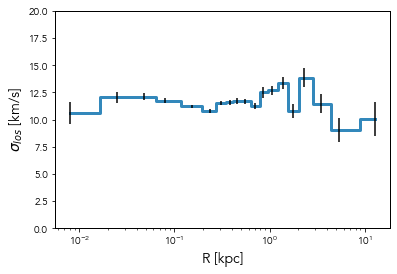

In [12]:
# method 1 
r_center, dispersion,error = system.dispersion(system._R,system._vz,system._error)

fig,ax = plt.subplots()
ax.step(r_center,dispersion,where='mid')
ax.errorbar(r_center,dispersion,yerr=error,fmt='none',ecolor='k',elinewidth=1.5)
ax.set(
    xscale = 'log',
    xlabel = 'R [kpc]',
    ylabel =r'$\sigma_{los}$ [km/s]',
    ylim   = (0,20),
);

In [13]:
system._cached_dispersion

{'los': (Array([8.05904570e-03, 2.48239784e-02, 4.79721953e-02, 7.94142067e-02,
         1.52598024e-01, 2.34538584e-01, 3.06581719e-01, 3.81059231e-01,
         4.50355973e-01, 5.51219547e-01, 7.09275163e-01, 8.59649211e-01,
         1.05203002e+00, 1.38063126e+00, 1.74463689e+00, 2.27819761e+00,
         3.47321533e+00, 5.30113787e+00, 1.26862081e+01], dtype=float64),
  Array([10.62691229, 12.05868339, 12.12320757, 11.75410151, 11.24697806,
         10.80874662, 11.50200159, 11.58121567, 11.70027956, 11.67941459,
         11.28565928, 12.52084557, 12.7076298 , 13.37900733, 10.82457669,
         13.86709061, 11.47350082,  9.07238275, 10.07115006], dtype=float64),
  Array([0.97751279, 0.53211124, 0.31924761, 0.23875125, 0.14306505,
         0.19627238, 0.18583755, 0.25914751, 0.25712758, 0.26299807,
         0.26984911, 0.49836738, 0.41235863, 0.56973069, 0.64231472,
         0.88479392, 0.87067046, 1.12010336, 1.5745384 ], dtype=float64))}

In [14]:
system._cached_dispersion['los'][0]

Array([8.05904570e-03, 2.48239784e-02, 4.79721953e-02, 7.94142067e-02,
       1.52598024e-01, 2.34538584e-01, 3.06581719e-01, 3.81059231e-01,
       4.50355973e-01, 5.51219547e-01, 7.09275163e-01, 8.59649211e-01,
       1.05203002e+00, 1.38063126e+00, 1.74463689e+00, 2.27819761e+00,
       3.47321533e+00, 5.30113787e+00, 1.26862081e+01], dtype=float64)

## Jeans Modeling

```python
from dynamicAll import models
```
models contains all of the built in parameterization of models we will use to fit the data.

As expected from this mock data, generated from the velocity dispersion profile of Draco, we see that the velocity dispersion is roughly constant with radius at around $12.5\rm~km~s^{-1}$

For our Jeans Modeling we need to initialize our Fit class

In [15]:
fit_cls = Fit()
# fit_cls  = Fit(tracer_model,dm_model,anisotropy_model)
# output = fit_cls.fit(data=data)

No tracer model defined.
Using default Plummer model.

No DM model defined.
Using default HernquistZhao model.

No anisotropy model defined.
using default BetaConstant model

No priors defined.
Using default priors for each model


If you call it this way you are using the default values for all parameters and priors.
This is equivalent to initializing the model as follows:

```python
priors = fit.Priors()

tracer_model     = models.Plummer
priors.add_prior('M', dist.LogUniform(1e-2,1e5))
priors.add_prior('b', dist.LogUniform(1e-3,1e3))

dm_model         = models.HernquistZhao

priors.add_prior('rhos', dist.LogUniform(jnp.exp(-2),jnp.exp(5)))
priors.add_prior('rs', dist.LogUniform(jnp.exp(-3),jnp.exp(3)))

priors.add_prior('a', dist.Uniform(-3,3))
priors.add_prior('b', dist.Uniform(.1,3))
priors.add_prior('c', dist.Uniform(.1,3))

anisotropy_model  = models.BetaConstant
priors.add_prior('beta0', dist.Uniform(-5,1))
```

In [16]:
priors = fit.Priors()

tracer_model     = models.Plummer
# priors.add_prior('tracer_M', dist.Normal(1e2,1e4))
# priors.add_prior('tracer_a', dist.LeftTruncatedDistribution(dist.Normal(.25,.50),0))
# priors.add_prior('tracer_a', dist.LogUniform(1e-1,1e0))

dm_model         = models.HernquistZhao

priors.add_prior('dm_rhos', dist.LogUniform(1e5,1e11))
priors.add_prior('dm_rs', dist.LogUniform(1e-2,1e1))

priors.add_prior('dm_gamma', dist.Uniform(-2,2))

anisotropy_model  = models.BetaConstant
# priors.add_prior('beta_0', dist.Uniform(-1,1))

In [17]:
jnp.exp(-3),jnp.exp(2)

(Array(0.04978707, dtype=float64, weak_type=True),
 Array(7.3890561, dtype=float64, weak_type=True))

In [18]:
fit_cls = fit.SphGalaxy(priors=priors)

No tracer model defined.
Using default Plummer model.

No DM model defined.
Using default HernquistZhao model.

No anisotropy model defined.
using default BetaConstant model



In [19]:
fit_cls._priors

Parameter: dm_rhos, Distribution: LogUniform, Bounds: (1.00e+05, 1.00e+11)
Parameter: dm_rs, Distribution: LogUniform, Bounds: (1.00e-02, 1.00e+01)
Parameter: dm_gamma, Distribution: Uniform, Bounds: (-2.00e+00, 2.00e+00)


Because this is our tracer model, we only have to define a prior on the scale radius of the tracer population, but we'll still define a prior on the total "Mass" of the tracers, but it's ultimately just the number of tracers.
We'll assume a uniform prior on the logarithm of the scale radius, with limits of 0.1 and 10 kpc.
There's a somewhat convenient Priors class that we can use to define our priors on each component of our model.
The default priors are based on previous authors works,  e.g. [(Chang et. al.)](https://academic.oup.com/mnras/article/507/4/4715/6358538)

$$
\begin{array}{lc}
\hline \text { Parameter } & \text { Prior } \\
\hline \log _{10}\left(r_* / \mathrm{kpc}\right) & {[-3,3]} \\
\log _{10}\left(L / L_{\odot}\right) & {[-2,5]} \\
\ln \left(\rho_0 /\left(M_{\odot} \mathrm{kpc}^{-3}\right)\right) & {[5,30]} \\
\left.\ln \left(r_s / \mathrm{kpc}\right)^{-1}\right) & {[-10,10]} \\
\bar{v} /\left(\mathrm{km} \mathrm{s}^{-1}\right) & {[-100,100]} \\
\gamma & {[-1,5]} \\
\hline
\end{array}
$$


The LogUniform distribution is a distribution over positive reals that is uniform in log space. It is useful for fitting parameters that naturally live on a log scale. Note that the distribution is the same regardless of the base of the logarithm.

In [23]:
mcmc = fit_cls.fit_dSph(
            data=system,
            num_chains=2,
            num_samples=4000)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

If you're running this on your laptop -- you may get a warning about the number of cores you're using. 
You can ignore this for now, although if you find the time to run this becoming large you may consider using a cluster with GPUs or TPUs to speed up the fitting process.

We'll user arviz and corner to visualize the results of our fit.
However, if you just want the samples you can write

```python
samples = mcmc.get_samples()
```

```python

In [ ]:
import arviz as az

inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dm_gamma,5.600000e-01,5.680000e-01,-5.840000e-01,1.380000e+00,0.020,0.014,856.0,1109.0,1.0
dm_rhos,1.192958e+08,7.722985e+07,2.458772e+07,2.713866e+08,2670294.344,1888842.013,855.0,1116.0,1.0
dm_rs,8.600000e-01,3.180000e-01,3.790000e-01,1.380000e+00,0.011,0.008,847.0,1087.0,1.0


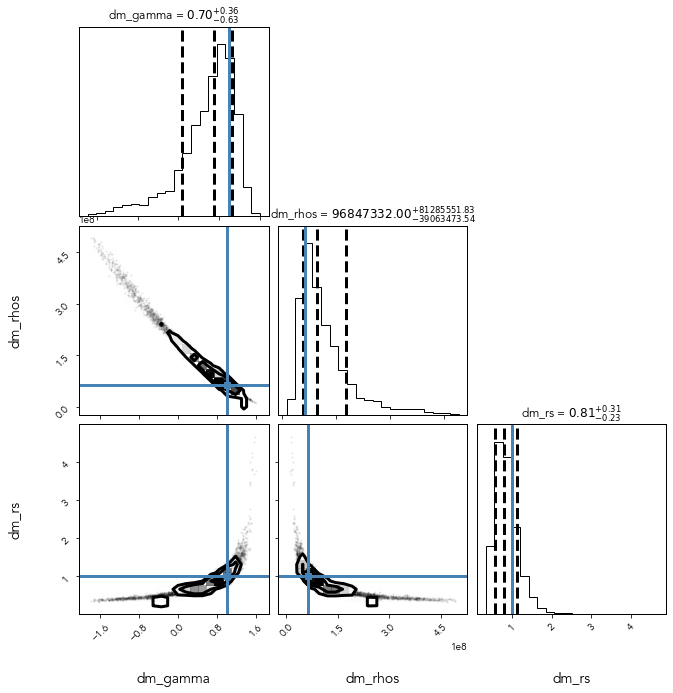

In [ ]:
import corner
fig,ax = plt.subplots(ncols=3,nrows=3,figsize=(10,10))

corner.corner(inf_data,fig=fig,
            quantiles=[0.16, 0.5, 0.84],
            show_titles=True,
            # title_fmt='.2e',
            truths=[1,6.4e7,1]);

# ax[2,1].set(
    # xlim=(1e5,1e8),
    # xscale='log'
# )
# ax = ax.flatten()
# ax[3].set(
#     yscale='log'
# )
# ax[7].set(
#     xscale='log'
# )

Now output is itself a class, with various convenience methods that will plot the results 